# Tutorial: Fitting the CMS $pp \rightarrow \gamma\gamma$ Higgs Discovery Data
> 12 - 25 June 2024, Asia-Europe-Pacific School of HEP (AEPSHEP) 2024, Nakhon Pathom, Thailand<br>
> Harrison B. Prosper

### Statistical model

We shall use $\texttt{RooFit}$ to fit the following 4-parameter statistical model
\begin{align}
    p(D | \theta) & = \exp(-(b + s)) \prod_{i=1}^N [(1 - \epsilon) \, f_b(x_i, a_1, a_2) + \epsilon \, f_s(x_i, m_{h}, \sigma_h)],  \text{ where}\\
    \epsilon & = \frac{s} {b + s}, \\
    D & = \{ x_i \}, \\
    \theta & = a_1, a_2, m_h, \sigma_h, \\
    f_b(x, a_1, a_2) & = \exp(-(a_1 \, z + a_2 \, z^2)) / A(a_1, a_2), (z = x / 100) \text{ and}\\
    f_s(x, m_h, \sigma_h) & = \mathcal{N}(x, m_{h}, \sigma_{h}) ,
\end{align}
to the CMS 7 and 8 TeV di-photon mass data, which was instrumental in the discovery of the Higgs boson at CERN in 2012.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

from ROOT import RooMsgService, RooWorkspace, RooFit, RooDataSet, RooCategory, RooArgList,\
TStopwatch, TCanvas, kRed

%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
# update fonts
FONTSIZE = 10
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

### Constants

In [3]:
MASSMIN  = 110.0                # minimum di-photon mass (GeV)
MASSMAX  = 160.0                # maximum di-photon mass (GeV)
MASSRANGE= MASSMAX-MASSMIN
MASSSCALE= 100.0                # scale by which to divide all masses
MASSBINS =  50

### Create workspace
We do this primarily to take advantage of the workspace's $\texttt{factory}$ method.

In [4]:
# suppress all messages except those that matter
RooMsgService.instance().setGlobalKillBelow(RooFit.FATAL)

# create empty workspace
wspace = RooWorkspace('higgs')

### Load $m_{\gamma\gamma}$ data

In [5]:
# create photon categories to be read (read all categories)
photonCat = RooCategory("pcat", "photon categories")
photonCat.defineType('photon0', 0)
photonCat.defineType('photon1', 1)
photonCat.defineType('photon2', 2)
photonCat.defineType('photon3', 3)
photonCat.defineType('photon4', 4)
photonCat.defineType('photon5', 5)

# import photon categories into workspace
# Note: the name of this method begins with an upper
# case to avoid a classh with the keyword "import"
wspace.Import(photonCat)

# create di-photon mass variable
wspace.factory('x[%f, %f]' % (MASSMIN, MASSMAX))
x = wspace.var('x')
x.SetTitle('m_{#gamma#gamma} (GeV)')

# read 7 TeV di-photon data
data = RooDataSet.read('../datasets/hgg7TeV.txt', RooArgList(photonCat, x))

# read 8 TeV di-photon data and append to 7 TeV data
data.append(RooDataSet.read('../datasets/hgg8TeV.txt', RooArgList(photonCat, x)))

# import data into workspace
wspace.Import(data)

wspace.Print()
data.Print()


RooWorkspace(higgs) higgs contents

variables
---------
(blindState,pcat,x)

datasets
--------
RooDataSet::dataset(pcat,x,blindState)

RooDataSet::dataset[pcat,x,blindState] = 30772 entries


### Create variables appearing in probability densities

In [6]:
ndata = data.numEntries()
print("number of entries: %d" % ndata)

# create background parameters
wspace.factory('b[%d, 0.0, %d]' % (ndata, 3*ndata))
wspace.factory('a1[ 7.5, -50, 50]')
wspace.factory('a2[-1.5, -50, 50]')

# background model: exp( -(a1*(x/100) + a2*(x/100)**2))
expr = 'expr::Z("-(a1*(x/100)+a2*(x/100)**2)", x, a1, a2)'
wspace.factory(expr)

wspace.factory('Exponential::bmodel(Z, 1)')
bmodel  = wspace.pdf('bmodel')

# signal model
wspace.factory('s[100, 0.0, 500.0]')
wspace.factory('mass[120, %f, %f]' % (MASSMIN, MASSMAX))
wspace.factory('sigma[1.0, 0.01, 10]')
wspace.factory('Gaussian::smodel(x, mass, sigma)')

# According to Wouter, the following produces a so-called extended pdf
# by default
# p(x|...) = exp(-(b+s)) * PROD p(x_i|...)
wspace.factory('SUM::model(b*bmodel, s*smodel)')
model  = wspace.pdf('model')

print("="*100)
wspace.Print()

number of entries: 30772

RooWorkspace(higgs) higgs contents

variables
---------
(a1,a2,b,blindState,mass,pcat,s,sigma,x)

p.d.f.s
-------
RooExponential::bmodel[ x=Z c=1 ] = 0.00134116
RooAddPdf::model[ b * bmodel + s * smodel ] = 0.00133682/1
RooGaussian::smodel[ x=x mean=mass sigma=sigma ] = 1.07004e-07

functions
--------
RooFormulaVar::Z[ actualVars=(x,a1,a2) formula="-(a1*(x/100)+a2*(x/100)**2)" ] = -6.61422

datasets
--------
RooDataSet::dataset(pcat,x,blindState)



### Fit the model to the di-photon data

In [7]:
ncores = 2
print("fit extended model to data")
print("="*80)

swatch = TStopwatch()
swatch.Start()
model.fitTo(data)
print("real time: %10.3f s" % swatch.RealTime())
# --------------------------------------------------------------
vbkg  = wspace.var('b')
vsig  = wspace.var('s')
vmass = wspace.var('mass')
vwidth=wspace.var('sigma')
va1   = wspace.var('a1')
va2   = wspace.var('a2')

# get results and compute a simple measure of signal significance
bkg   = vbkg.getVal()
ebkg  = vbkg.getError()
sig   = vsig.getVal()
esig  = vsig.getError()
mass  = vmass.getVal()
emass = vmass.getError()
width = vwidth.getVal()
ewidth= vwidth.getError()
zvalue= sig / esig

a1 = va1.getVal()
a2 = va2.getVal()
results = [mass, emass, width, ewidth, sig, esig, bkg, ebkg, a1, a2]

print("="*80)
print("background: %10.1f +\-%-5.1f GeV" % (bkg, ebkg))
print("signal:     %10.1f +\-%-5.1f" % (sig, esig))
print("mass:       %10.1f +\-%-4.1f GeV" % (mass, emass))
print("width:      %10.1f +\-%-4.1f GeV" % (width, ewidth))
print("sig/esig:   %10.1f" % zvalue)
print()

fit extended model to data
real time:      0.878 s
background:    30570.9 +\-185.7 GeV
signal:          200.9 +\-63.3 
mass:            124.8 +\-0.3  GeV
width:             0.9 +\-0.3  GeV
sig/esig:          3.2

Minuit2Minimizer: Minimize with max-calls 3000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = -170119.649519430561
Edm   = 0.00617067995160415321
Nfcn  = 192
a1	  = 7.3721	 +/-  0.635221	(limited)
a2	  = -1.54832	 +/-  0.240014	(limited)
b	  = 30570.9	 +/-  184.953	(limited)
mass	  = 124.774	 +/-  0.294463	(limited)
s	  = 200.856	 +/-  61.4709	(limited)
sigma	  = 0.850457	 +/-  0.270196	(limited)


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -170089.6907 Edm =       43.27137293 NCalls =     27
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -170099.1621
  Edm           : 38.8562693
  Internal parameters:	[     0.1505682728   -0.03000450182    -0.3398369095    -0.4319430119    -0.6435011088    -0.9303042618]	
  Internal gradient  :	[      7041.135486      18798.84491      144.8085526     -30.19418067     -4.801097242      7.310453473]	
  Internal covariance matrix:
[[  1.4516842e-06              0              0              0              0              0]
 [              0   2.027555e-07              0              0              0              0]
 [              0              0  3.2683556e-05              0              0          

### Make a plot of the results using $\texttt{matplotlib}$
Compute normalization factor for background density using $\texttt{sympy}$.

In [8]:
import sympy as sm
sm.init_printing() # activate pretty-printing of equations

Define symbols of background model

In [9]:
a1, z, z0, z1 = sm.symbols('a_1,z,z0,z1', real=True, positive=True)
a2 = sm.symbols('a_2', real=True, positive=False)
a1,a2,z,z0,z1

Integrate
\begin{align}
    f_b(z, \theta_b) & = \exp(-(a_1 \, z + a_2 \, z^2)),\quad z \equiv x / 100, \quad \theta_b \equiv a_1, a_2,\\
    A(\theta_b) & = \int_{z_0}^{z_1} f_b(z, \theta_b) \, dz .
\end{align}

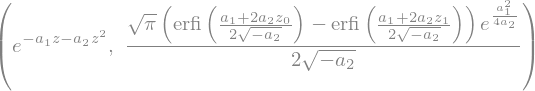

In [10]:
f = sm.exp(-(a1*z + a2*z**2))
A = sm.integrate(f, (z, z0, z1)).simplify()
f, A

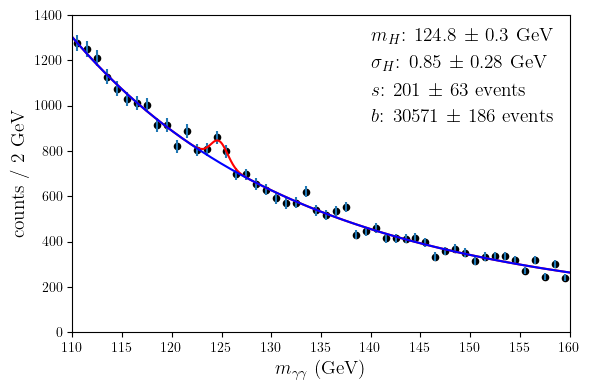

In [11]:
def plot_fit_results(X, results, symb,
                     xbins=MASSBINS, 
                     xmin=MASSMIN,
                     xmax=MASSMAX,
                     xscale=MASSSCALE,
                     ymin=0.0, 
                     ymax=1400, 
                     ftsize=14,
                     filename='hgg_fit.png'):

    y, a1, a2, z, z0, z1 = symb

    mass, emass, width, ewidth, sig, esig, bkg, ebkg, A1, A2 = results

    # normalized background density
    
    # evaluate the normalization factor for the background density
    norm_b = y.evalf(subs={a1:A1, a2:A2, z0:xmin/xscale, z1:xmax/xscale})

    def fb(x):
        z = x / xscale
        f = np.exp(-(A1*z + A2*z**2))/norm_b
        return f

    # normalized signal density
    norm_s = width * np.sqrt(2*np.pi) 
    
    def fs(x):
        f = np.exp(-((x - mass)/width)**2/2)/norm_s
        return f

    mggbins = 501
    mgg = np.linspace(xmin, xmax, mggbins)
    mgg = (mgg[1:]+mgg[:-1])/2 # get bin centers
    dm  = (xmax-xmin)/xbins
    s = sig * fs(mgg) * dm
    b = bkg * fb(mgg) * dm / xscale
    sb = s + b 

    # create an empty figure
    fig = plt.figure(figsize=(6, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    
    ticks = np.linspace(xmin, xmax, 11)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(ticks)
    ax.set_xlabel(r'$m_{\gamma\gamma}$ (GeV)', fontsize=ftsize)

    ax.set_ylim(ymin, ymax)
    #ax.set_yticks(ticks)
    ax.set_ylabel(r'counts / 2 GeV', fontsize=ftsize)

    c, m = np.histogram(X, bins=xbins, range=(xmin, xmax))
    m  = (m[1:]+m[:-1])/2 # get bin centers
    dc = np.sqrt(c)
    
    ax.scatter(m, c, s=20, color='black')
    ax.errorbar(m, c, yerr=dc, linestyle='')
    ax.plot(mgg, sb, color='red')
    ax.plot(mgg, b, color='blue')

    # annotate
    xpos = xmin + 0.6*(xmax-xmin)
    ystep= (ymax-ymin)/12
    ypos = ymax - ystep
    ax.text(xpos, ypos, f'$m_H$: {mass:6.1f} $\pm${emass:6.1f} GeV', fontsize=14); ypos -= ystep
    ax.text(xpos, ypos, f'$\sigma_H$: {width:6.2f} $\pm${ewidth:6.2f} GeV', fontsize=14); ypos -= ystep
    ax.text(xpos, ypos, f'$s$: {sig:8.0f} $\pm${esig:8.0f} events', fontsize=14); ypos -= ystep
    ax.text(xpos, ypos, f'$b$: {bkg:8.0f} $\pm${ebkg:8.0f} events', fontsize=14)
    #ax.grid(True, which="both", linestyle='-')
    
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

# ------------------------------------------------------
mgg  = data.to_numpy()['x']     # di-photon masses
symb = (A, a1, a2, z, z0, z1)   # sympy symbols
plot_fit_results(mgg, results, symb)